In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from class_function_V1 import TimeSeriesAnalysis #Função que processa os dados, separando no grupo de 53 setores
import numpy as np
from pySSA.core import MSSA
from pySSA.simple import SSA


# Leitura do arquivo Excel
df_raw = pd.read_excel(r"D:\OneDrive\Organizar UFSC\Documentos\TCC\Data_set\Base de Dados.xlsx")
df_raw = df_raw.drop(['29.1 Fabricação de automóveis, camionetas e utilitários'], axis=1)

numeric_cols = df_raw.select_dtypes(include=[np.number]).columns
df_log = df_raw.copy()
df_log[numeric_cols] = np.log(df_raw[numeric_cols])

# # Criação de instância da classe TimeSeriesAnalysis=
tsa = TimeSeriesAnalysis(df_log)

#tsa.df_macro_sectors= tsa.df_macro_sectors.loc[:, ['10.1', '10.7', '13.1','17.1','19.2','19.3','20.5','22.2','23.1','23.2','24.1','24.5','26.2','26.2','26.4','27.4','28.1','28.3','28.5','28.6']]

tsa.df_macro_sectors.head()

10.1      10.3      10.4      10.5      10.6      10.7      10.8  \
0  4.515331  4.054910  3.906180  4.661924  4.558232  3.536038  4.107816   
1  4.421800  3.735329  4.241995  4.513231  4.417194  3.528083  3.998127   
2  4.437739  3.566673  4.601538  4.529859  4.532730  3.277851  4.144940   
3  4.507316  3.616461  4.679233  4.536689  4.548309  3.727957  4.144719   
4  4.528129  3.688902  4.665151  4.480409  4.601294  4.748746  4.126926   

       11.1      11.2      13.1  ...      28.1      28.3      28.5      28.6  \
0  4.268231  3.993507  4.998449  ...  4.234316  4.143789  3.545596  4.217789   
1  4.143932  3.969375  4.992210  ...  4.332615  4.239395  3.719582  4.182698   
2  4.198235  4.010407  5.086040  ...  4.359103  4.373216  3.810535  4.349028   
3  4.265418  4.000468  5.153646  ...  4.455630  4.316473  3.959796  4.333748   
4  4.270458  3.982138  5.162835  ...  4.464872  4.321764  4.011917  4.352513   

       29.2      29.3      29.4      31.0      32.1      32.9  
0  3.764050  4.200043  4.226908  4.372683  3.242279  4.488433  
1  3.864202  4.144594  4.265512  4.214923  3.238978  4.347842  
2  3.997371  4.229685  4.336743  4.379752  4.011460  4.352726  
3  4.055660  4.327372  4.382654  4.455456  4.306655  4.353239  
4  3.987235  4.230950  4.352051  4.387869  4.452716  4.317744  

[5 rows x 52 columns]

-------------
### 2. Modelo Holt - Winters
-------------

In [21]:
# import matplotlib.pyplot as plt

# def plot_predictions(result_df, setor,test_size,df_macro_sectors):
#     subset = result_df[result_df['Setor'] == setor]
#     if subset.empty:
#         print("Não foram encontrados resultados para o setor especificado.")
#         return

#     best_model = subset['Modelo'].values[0]
#     series = df_macro_sectors[setor]
#     train_data, test_data = train_test_split(series, test_size=test_size, shuffle=False)

#     plt.figure(figsize=(10, 6))
#     plt.plot(range(len(test_data)), test_data, label='Valores reais')
#     plt.plot(range(len(test_data)), best_model.forecast(len(test_data)), label='Previsões')
#     plt.xlabel('Período')
#     plt.ylabel('Valores')
#     plt.title('Holt-Winters - Setor: ' + setor)
#     plt.legend()
#     plt.show()
    
#     # plt.figure(figsize=(10, 6))
#     # plt.plot(range(len(series)), series, label='Valores reais')
#     # plt.plot(range(len(series)), best_model.forecast(len(series)), label='Previsões')
#     # plt.xlabel('Período')
#     # plt.ylabel('Valores')
#     # plt.title('Holt-Winters - Setor: ' + setor)
#     # plt.legend()
#     # plt.show()

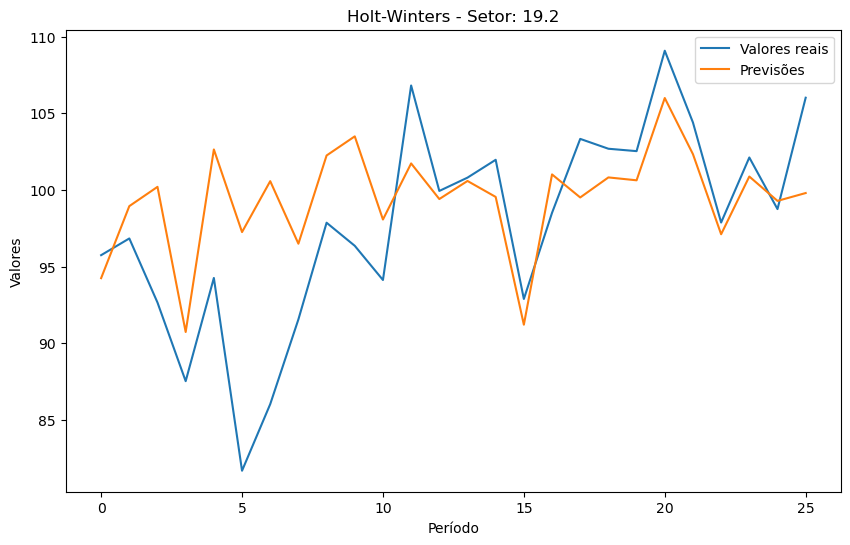

In [24]:
# plot_predictions(HW.result_df, '19.2', 0.1, tsa.df_macro_sectors)

--------------------------------

----------------------

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid
import joblib

class HoltWinters:
    def __init__(self, df_in):
        self.df_in = df_in
        self.models = {}
        self.best_models = {}
        self.result_df = None

    def holt_winters_model(self, series, trend_met, seasonal_met, seasonal_periods):
        model = ExponentialSmoothing(series, trend=trend_met, seasonal=seasonal_met, seasonal_periods=seasonal_periods)
        model = model.fit()
        return model

    def calculate_metrics(self, actual, forecast):
        error = forecast - actual
        mse = np.mean(error ** 2)
        mae = np.mean(np.abs(error))
        mape = np.mean(np.abs(error / actual))
        eqa = np.sum(error ** 2)
        rmse = np.sqrt(mse)
        rrmse = rmse / np.mean(actual)
        return mse, mae, mape, eqa, rmse, rrmse

    def select_best_holt_winters_model(self, metric,test_size):
        result_df = pd.DataFrame(columns=['Setor', 'Best Metric', 'trend', 'Seasonal', 'Seasonal_Periods',
                                          'Modelo','MSE_In-Sample','EQA_In-Sample','RMSE_In-Sample','RRMSE_In-Sample',
                                          'MAE_In-Sample','MAPE_In-Sample','MSE_Out-of-Sample','EQA_Out-of-Sample',
                                          'RMSE_Out-of-Sample','MAE_Out-of-Sample','MAPE_Out-of-Sample'])

        result_rows = []
        self.test_size = test_size
        seasonal_periods_range = range(2, 48)
        trend_met_range = ['add', 'mul']
        seasonal_met_range = ['add', 'mul']

        param_grid = ParameterGrid({'seasonal_periods': seasonal_periods_range, 'trend_met': trend_met_range, 'seasonal_met': seasonal_met_range})

        for col in self.df_in:
            series = self.df_in[col]
            train_size = len(series) - test_size
            train_data = series[:train_size]
            test_data = series[train_size:]

            best_metric = float('inf')
            best_model = None
            best_trend = None
            best_seasonal = None
            best_seasonal_periods = None

            for params in param_grid:
                seasonal_periods = params['seasonal_periods']
                trend_met = params['trend_met']
                seasonal_met = params['seasonal_met']

                model = self.holt_winters_model(train_data, trend_met, seasonal_met, seasonal_periods)
                forecast_train = model.predict(start=0, end=len(train_data)-1)
                forecast_test = model.forecast(len(test_data))
                
                if metric == 'mae':
                    current_metric = np.abs(forecast_test - test_data).mean()
                elif metric == 'mse':
                    current_metric = ((forecast_test - test_data) ** 2).mean()
                elif metric == 'mape':
                    current_metric = (np.abs(forecast_test - test_data) / test_data).mean()
                elif metric == 'mape':
                    current_metric = (np.abs(forecast_test - test_data) / test_data).mean()
                elif metric == 'eqa':
                        current_metric = np.sum((forecast_test.values - test_data.values)**2)

                if current_metric < best_metric:
                    best_metric = current_metric
                    best_model = model
                    best_trend = trend_met
                    best_seasonal = seasonal_met
                    best_seasonal_periods = seasonal_periods

            # Calcular previsões finais
            forecast_train = best_model.predict(start=0, end=len(train_data)-1)
            forecast_test = best_model.forecast(len(test_data))

            # Plotar gráfico de erro
            plt.figure(figsize=(12, 4))
            plt.plot(train_data.index, train_data.values, label='Dados de treinamento')
            plt.plot(test_data.index, test_data.values, label='Dados de teste')
            plt.plot(train_data.index, forecast_train, label='Previsão in-sample')
            plt.plot(test_data.index, forecast_test, label='Previsão out-of-sample')
            plt.xlabel('Data')
            plt.ylabel('Valor')
            plt.title(f'Previsão Holt-Winters - {col}')
            plt.legend()
            plt.show()

            # Calcular métricas
            in_sample_mse, in_sample_mae, in_sample_mape, in_sample_eqa, in_sample_rmse, in_sample_rrmse = self.calculate_metrics(train_data, forecast_train)
            out_of_sample_mse, out_of_sample_mae, out_of_sample_mape, out_of_sample_eqa, out_of_sample_rmse, out_of_sample_rrmse = self.calculate_metrics(test_data, forecast_test)

            result_rows.append({'Setor': col, 'Best Metric': best_metric, 'trend': best_trend,
                                'Seasonal': best_seasonal, 'Seasonal_Periods': best_seasonal_periods,
                                'Modelo': best_model, 'MSE_In-Sample': in_sample_mse, 'EQA_In-Sample': in_sample_eqa,
                                'RMSE_In-Sample': in_sample_rmse, 'RRMSE_In-Sample': in_sample_rrmse,'MAE_In-Sample': in_sample_mae, 'MAPE_In-Sample': in_sample_mape, 
                                'MSE_Out-of-Sample': out_of_sample_mse,'EQA_Out-of-Sample': out_of_sample_eqa, 'RMSE_Out-of-Sample': out_of_sample_rmse,
                                'RRMSE_Out-of-Sample': out_of_sample_rrmse, 'MAE_Out-of-Sample': out_of_sample_mae, 'MAPE_Out-of-Sample': out_of_sample_mape})
        # joblib.dump(result_df, 'out_HW.pkl')
        result_df.to_csv('out_HW.csv', index=False)
        self.result_df = pd.DataFrame(result_rows)
        return self.result_df

    def generate_forecast_errors(self):
        #coloque o error_df
        errors_df = pd.DataFrame(columns=['Setor', 'h(período da previsão)','MSE_In-Sample','EQA_In-Sample','RMSE_In-Sample','RRMSE_In-Sample','MAE_In-Sample','MAPE_In-Sample','MSE_Out-of-Sample','EQA_Out-of-Sample','RMSE_Out-of-Sample','MAE_Out-of-Sample','MAPE_Out-of-Sample'])

        for _, row in self.result_df.iterrows():
            sector = row['Setor']
            model = row['Modelo']
            series = self.df_in[sector]
            train_size = len(series) - self.test_size
            train_data = series[:train_size]
            test_data = series[train_size:]

            for h in [1, 6, 9, 12]:
                in_sample_forecast = model.predict(start=0, end=train_size-1)
                in_sample_actual = train_data

                forecast = model.predict(start=train_size, end=train_size+h-1)
                actual = test_data[:h]

                in_sample_mse, in_sample_mae, in_sample_mape, in_sample_eqa, in_sample_rmse, in_sample_rrmse = self.calculate_metrics(in_sample_actual, in_sample_forecast)
                out_of_sample_mse, out_of_sample_mae, out_of_sample_mape, out_of_sample_eqa, out_of_sample_rmse, out_of_sample_rrmse = self.calculate_metrics(actual, forecast)

                errors_df = errors_df.append({'Setor': sector, 'h(período da previsão)': h, 'MSE_In-Sample': in_sample_mse, 'EQA_In-Sample': in_sample_eqa,
                                                'RMSE_In-Sample': in_sample_rmse, 'RRMSE_In-Sample': in_sample_rrmse,'MAE_In-Sample': in_sample_mae, 'MAPE_In-Sample': in_sample_mape, 
                                                'MSE_Out-of-Sample': out_of_sample_mse,'EQA_Out-of-Sample': out_of_sample_eqa, 'RMSE_Out-of-Sample': out_of_sample_rmse,'RRMSE_Out-of-Sample': out_of_sample_rrmse, 'MAE_Out-of-Sample': out_of_sample_mae, 'MAPE_Out-of-Sample': out_of_sample_mape}, ignore_index=True)

        return errors_df





c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning:

overflow encountered in matmul



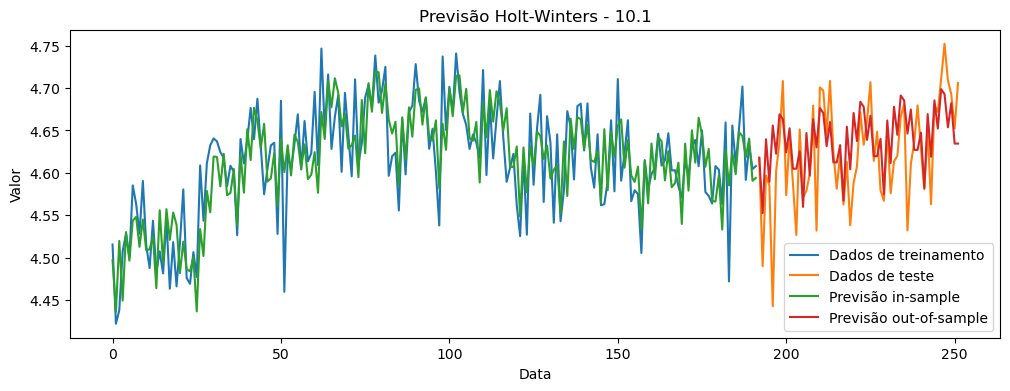

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\sta

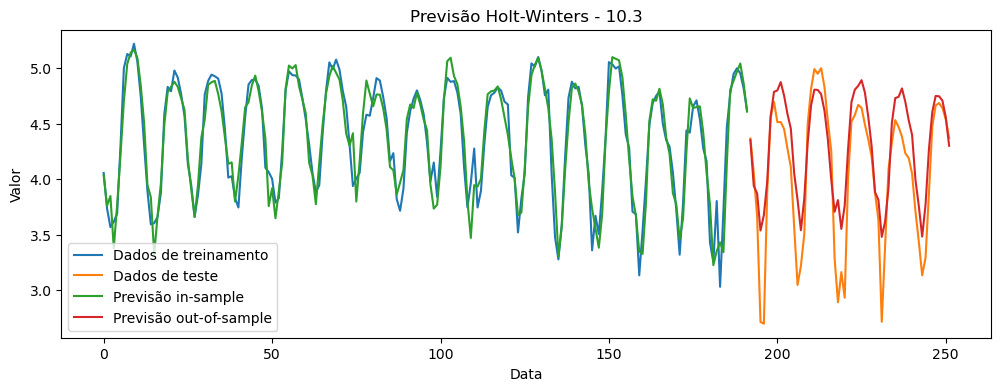

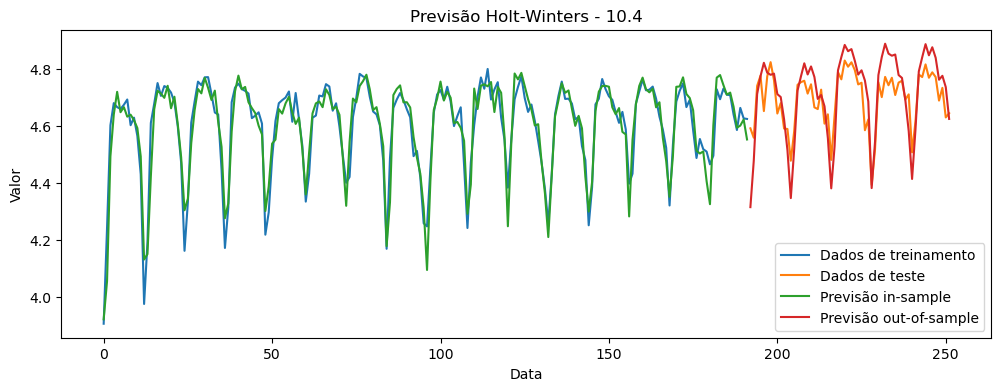

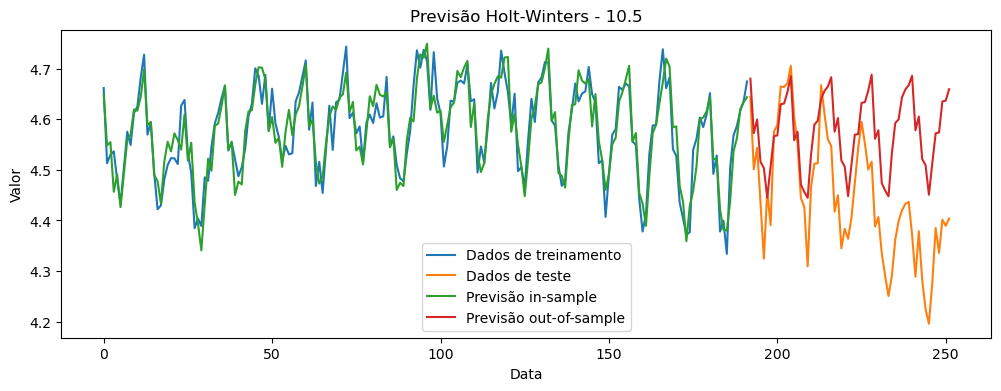

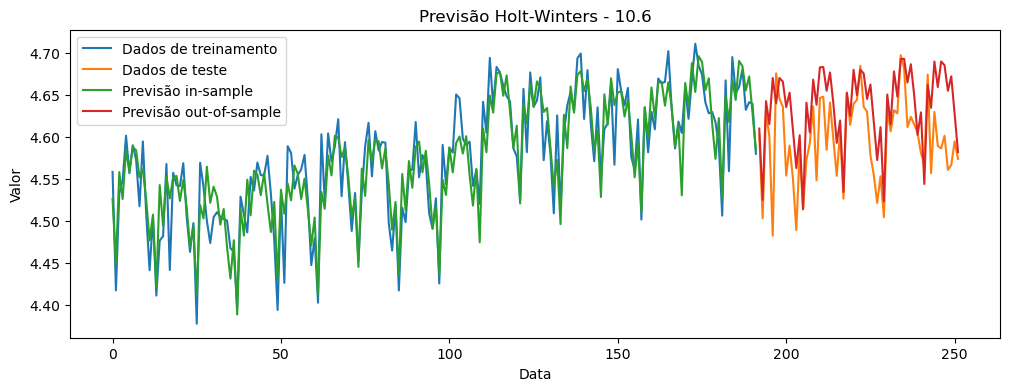

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\sta

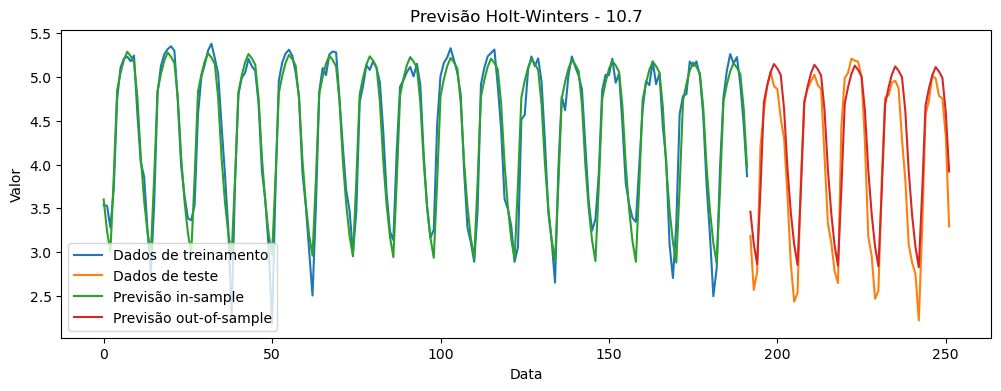

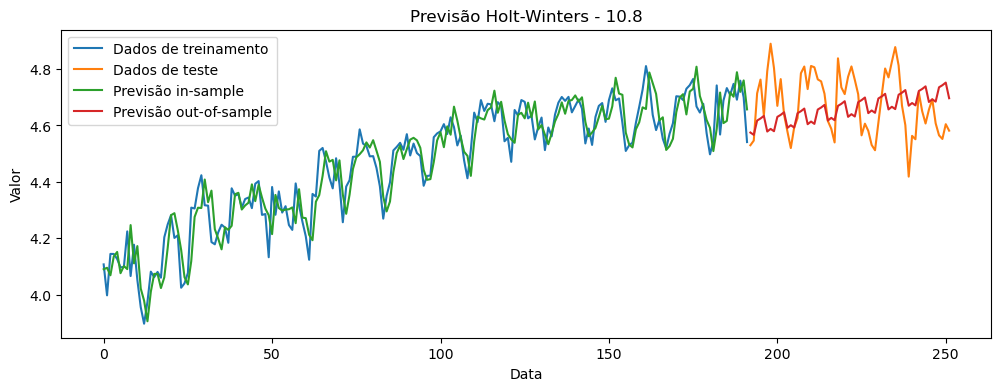

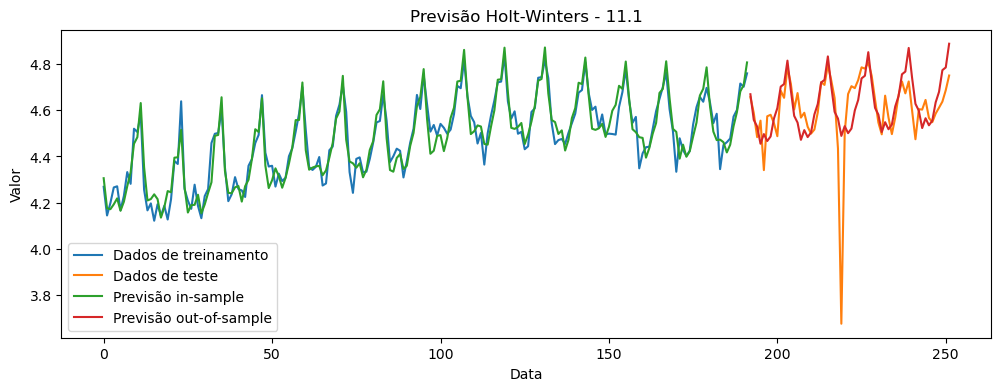

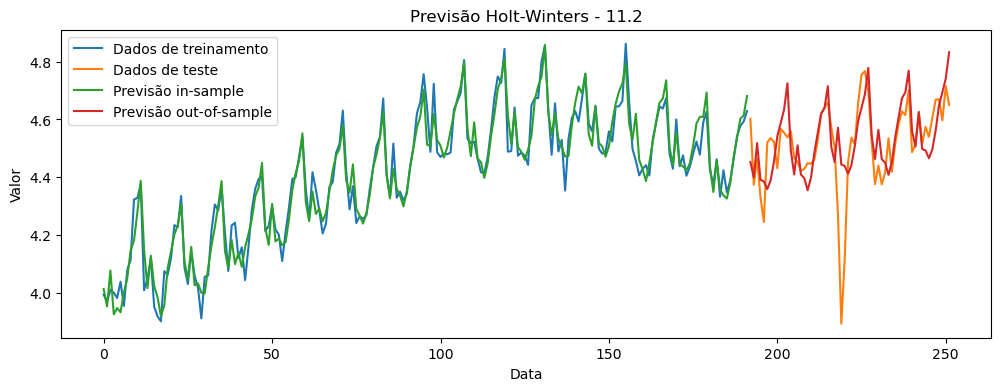

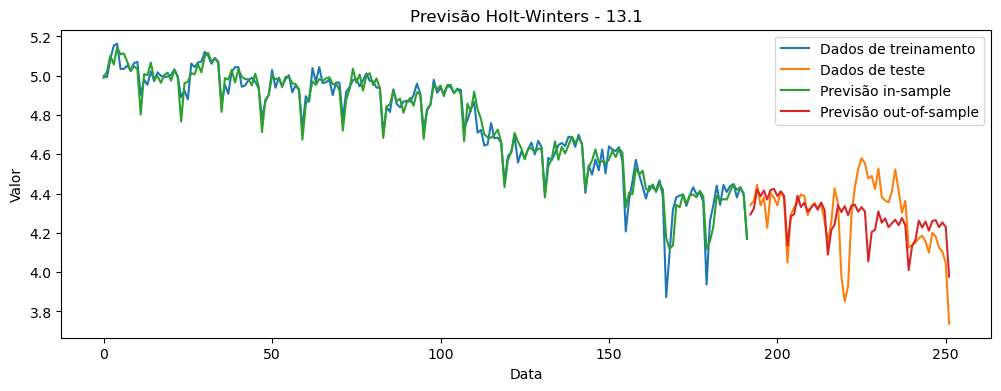

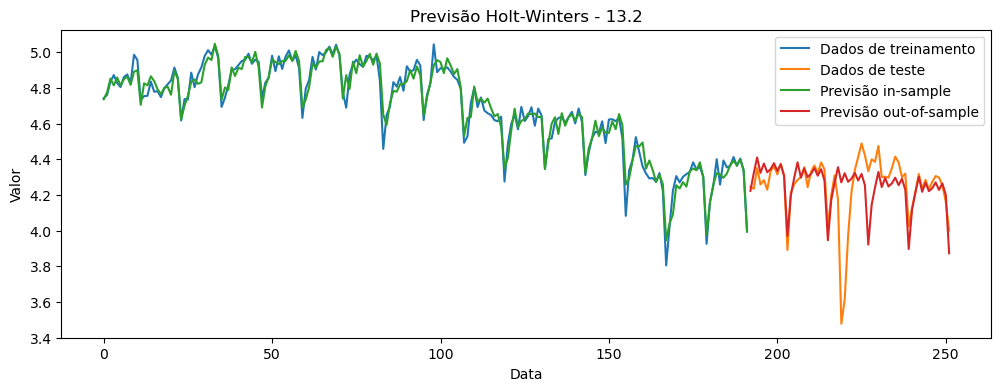

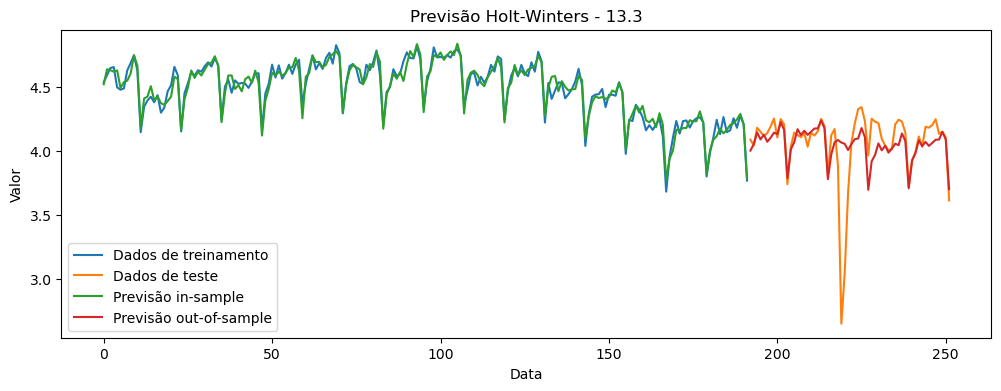

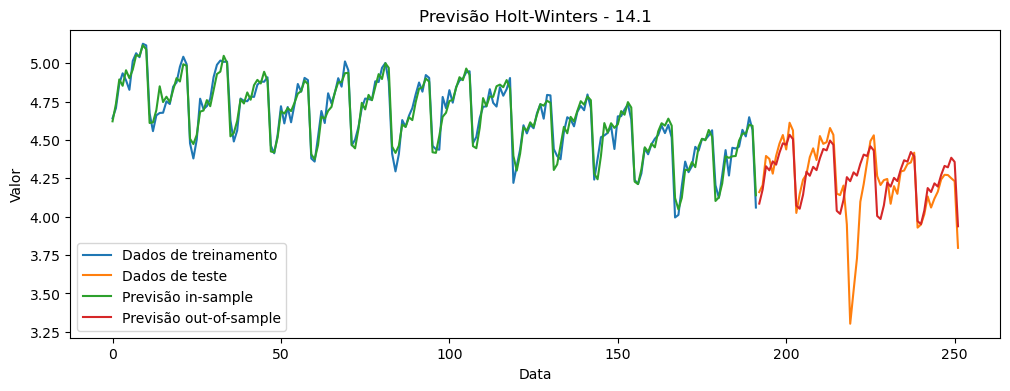

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



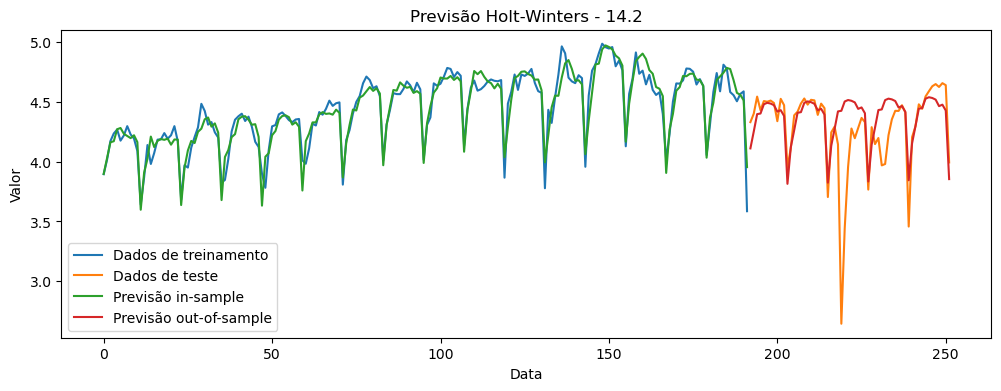

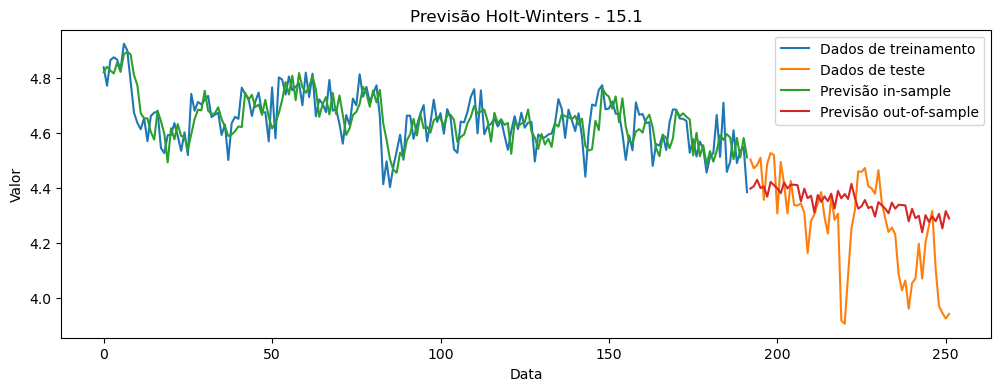

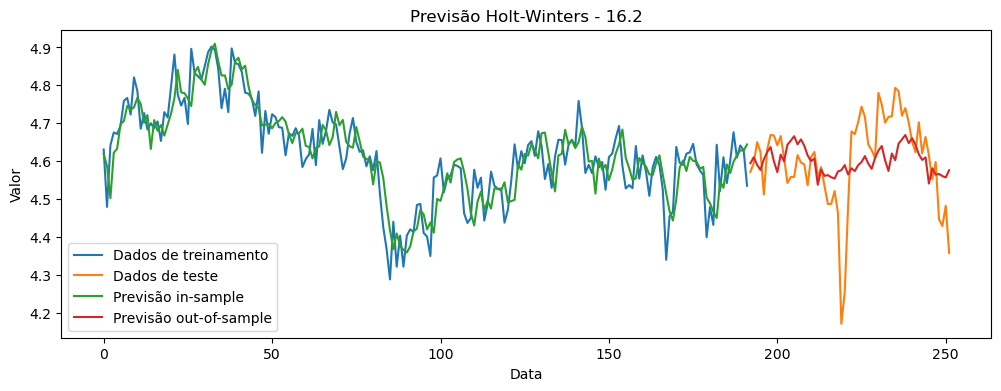

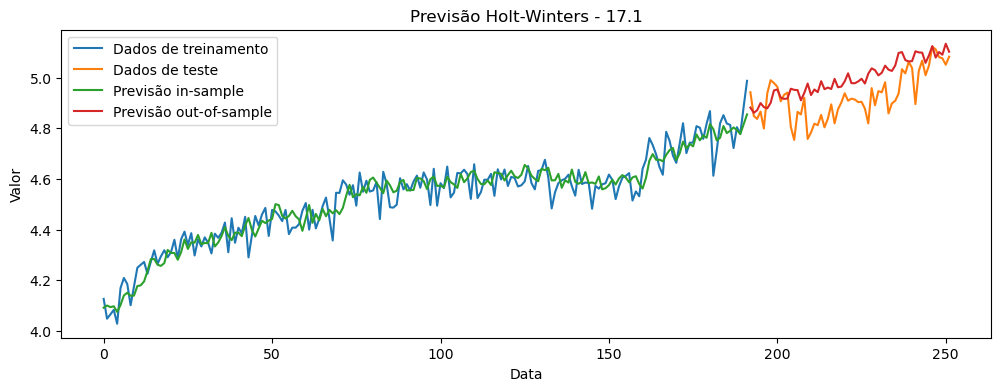

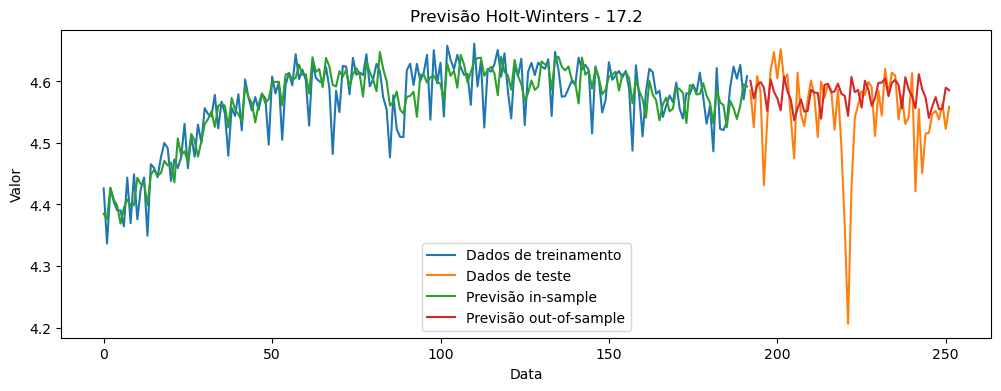

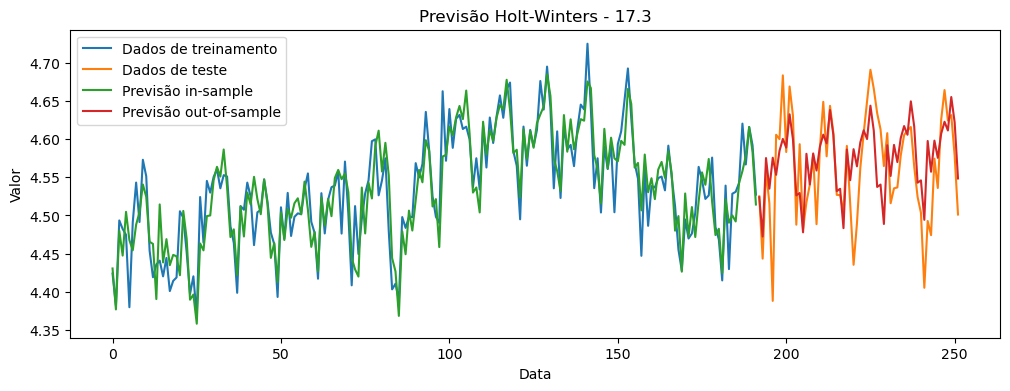

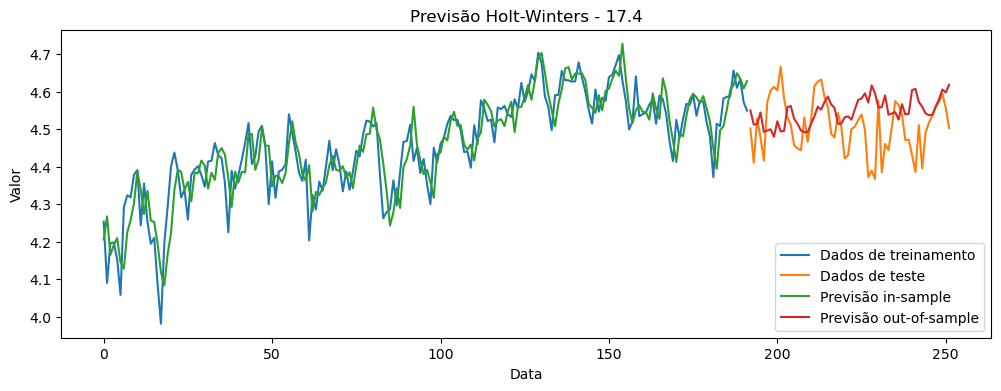

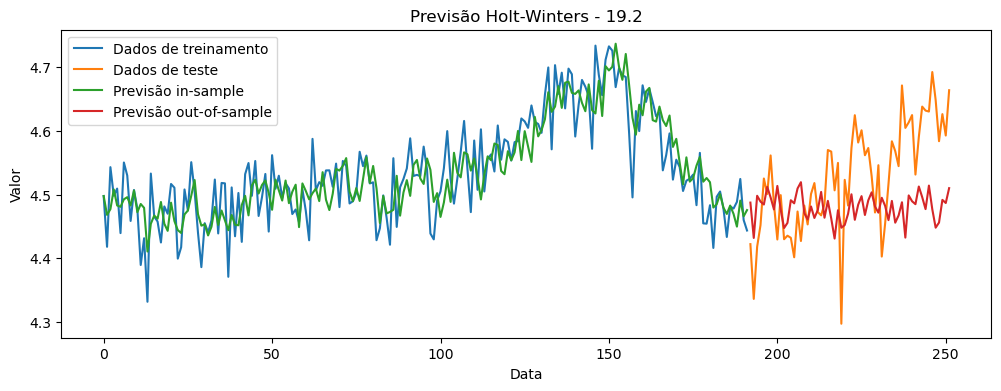

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\sta

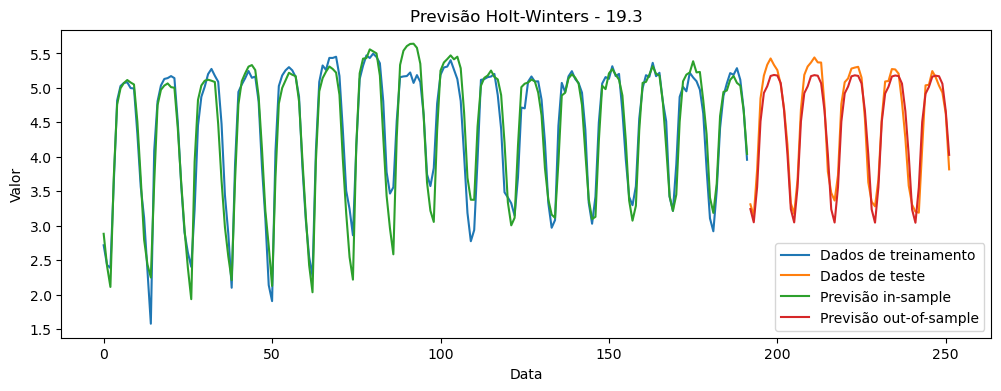

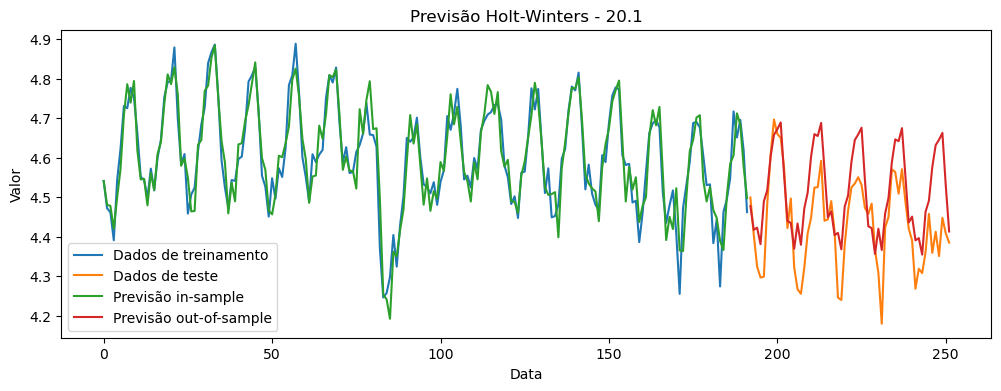

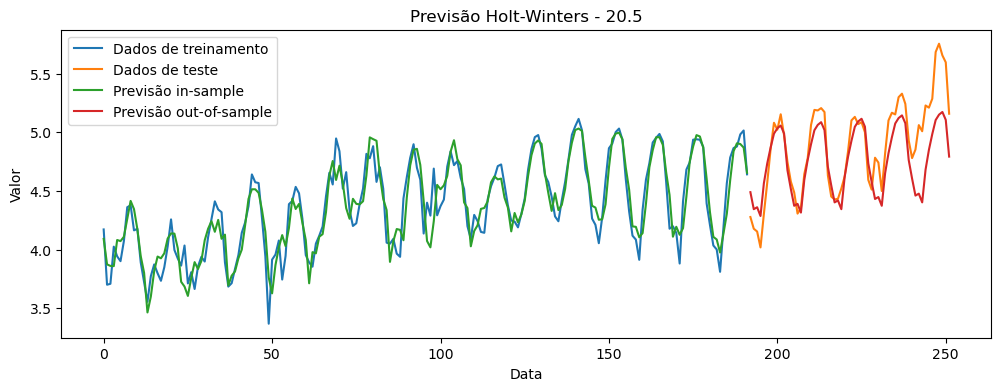

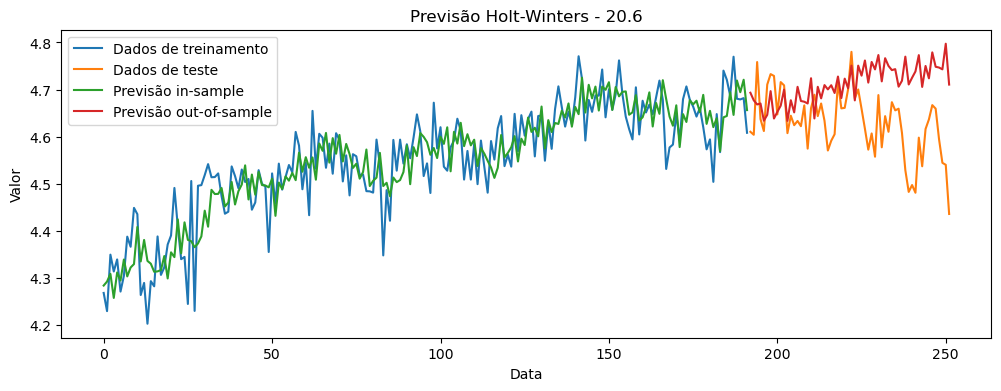

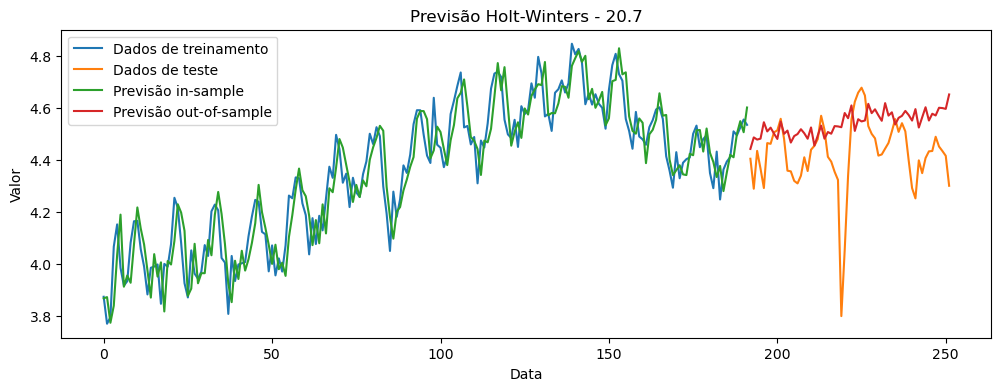

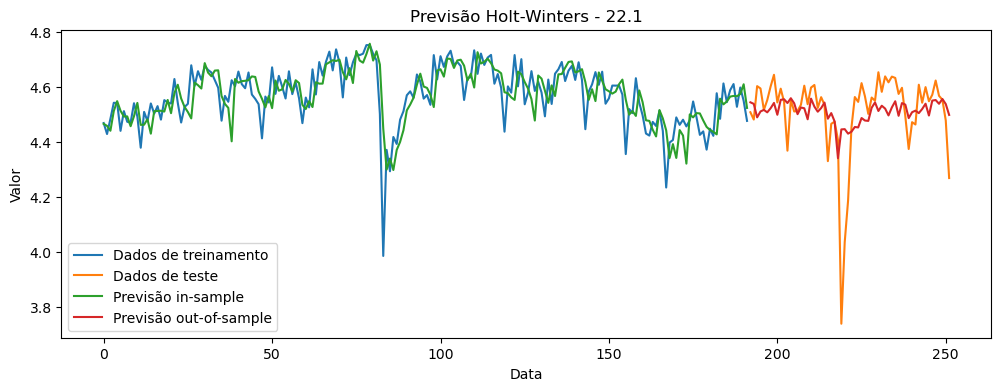

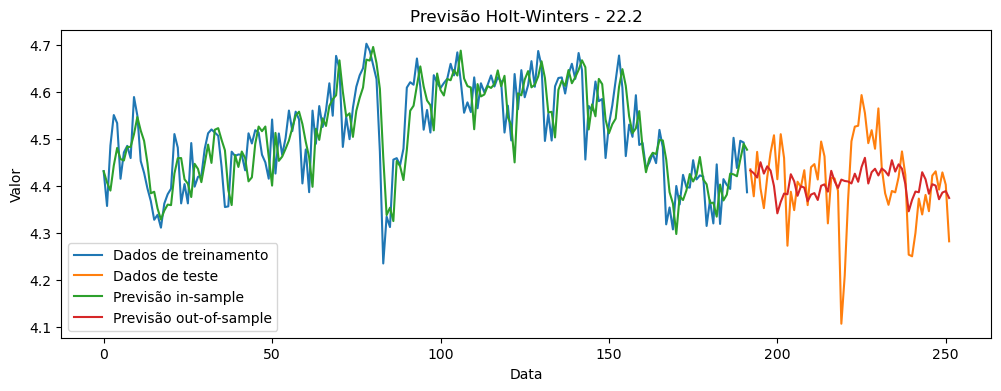

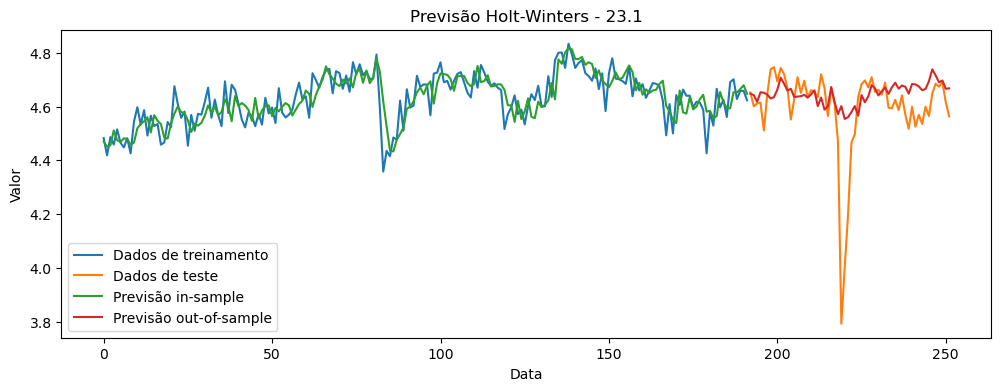

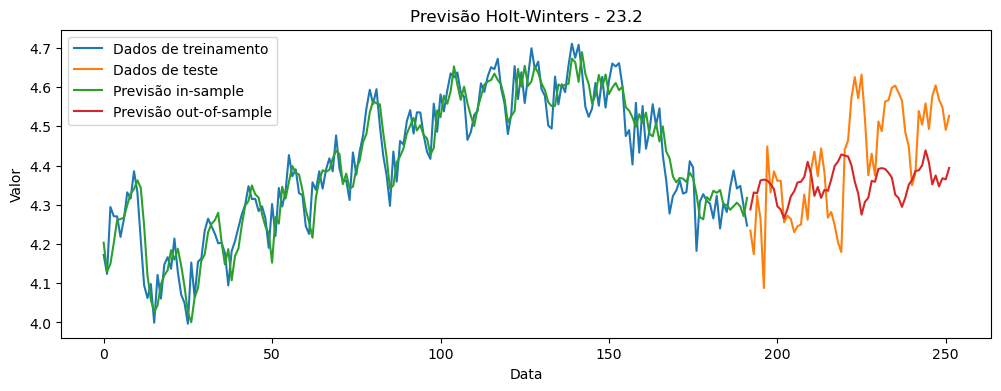

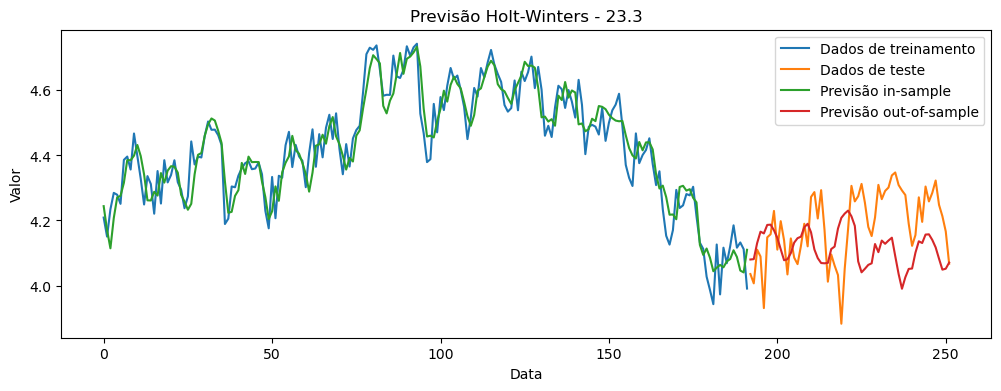

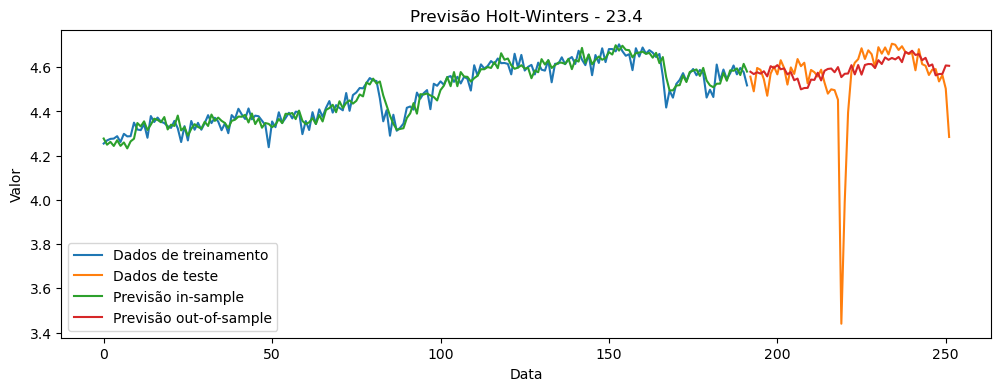

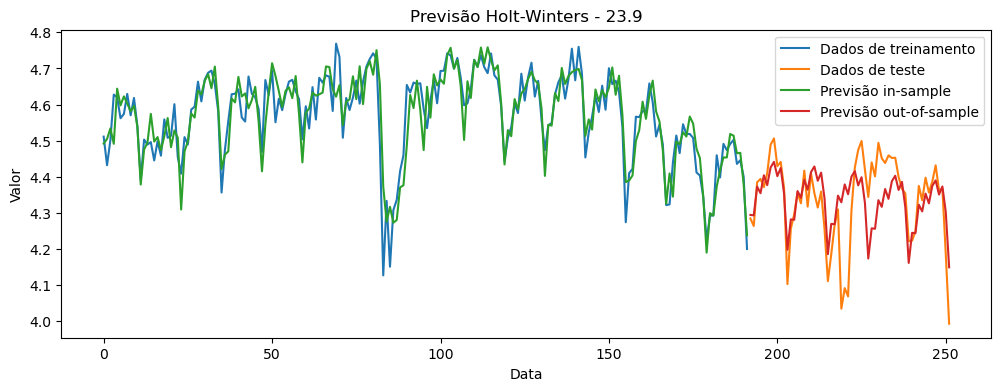

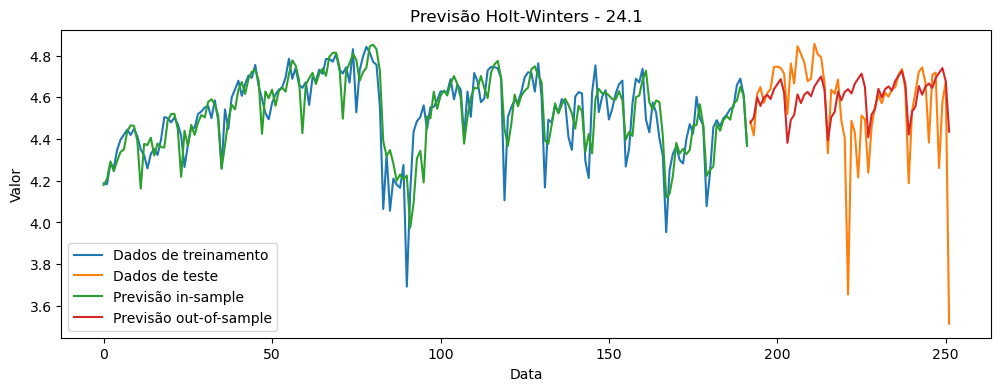

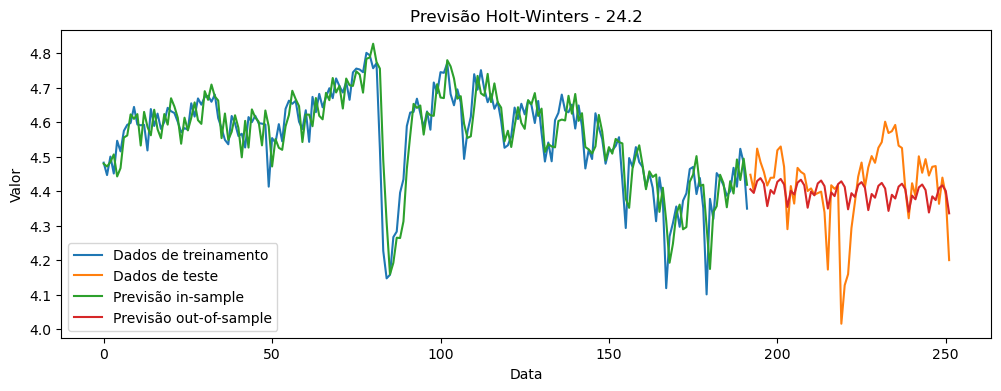

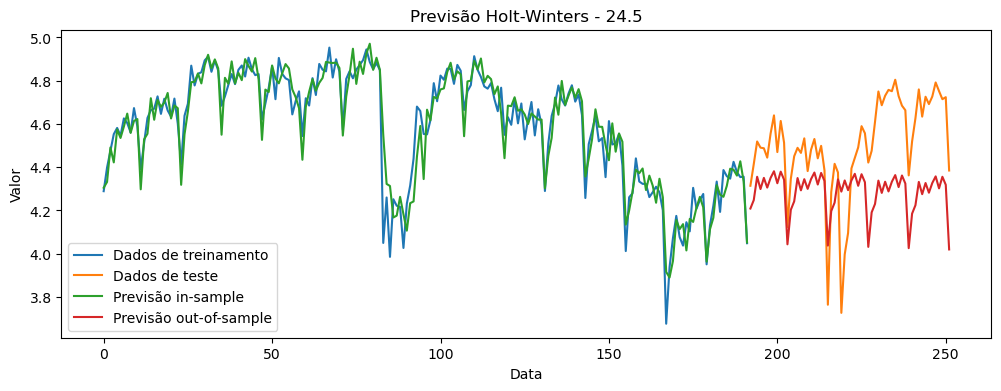

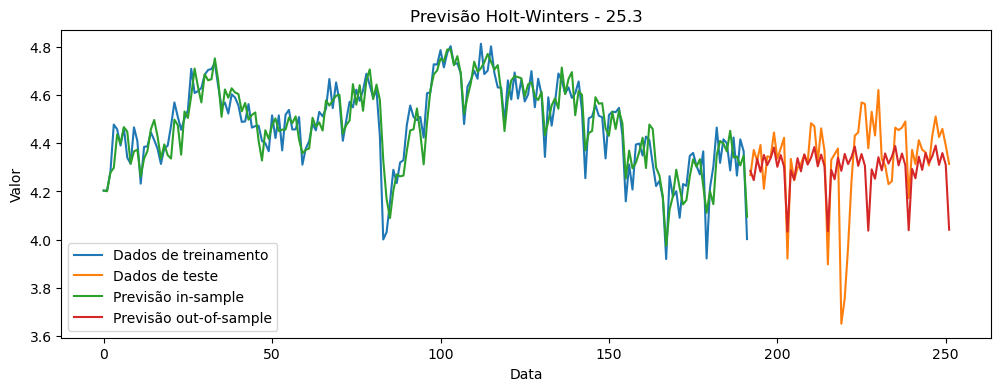

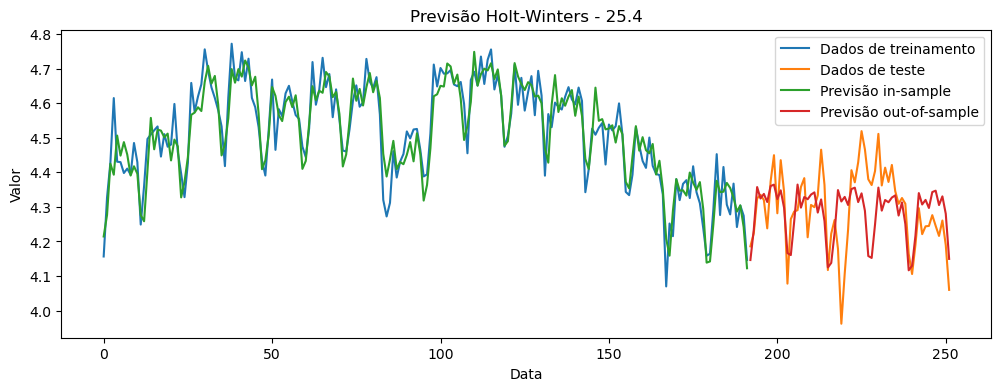

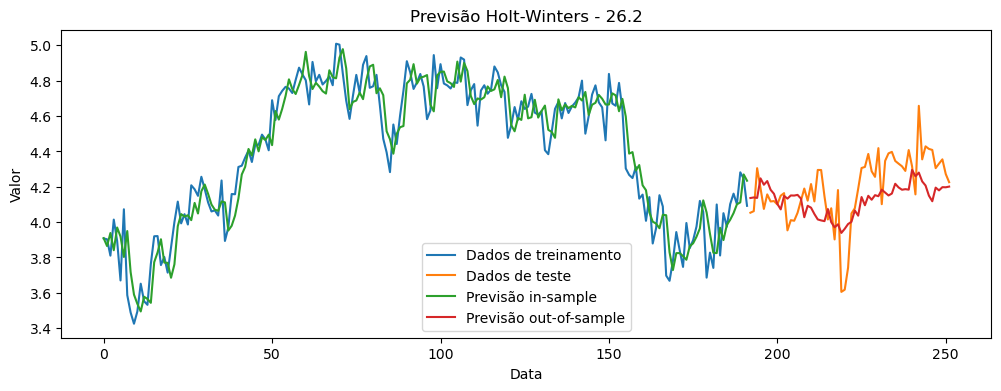

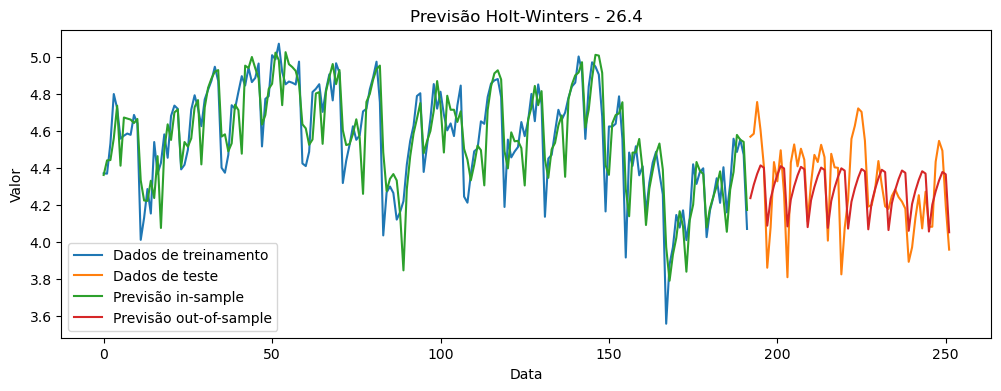

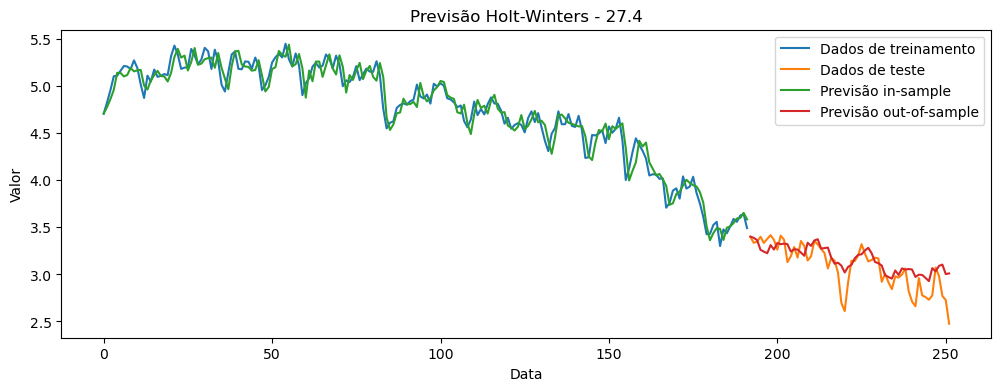

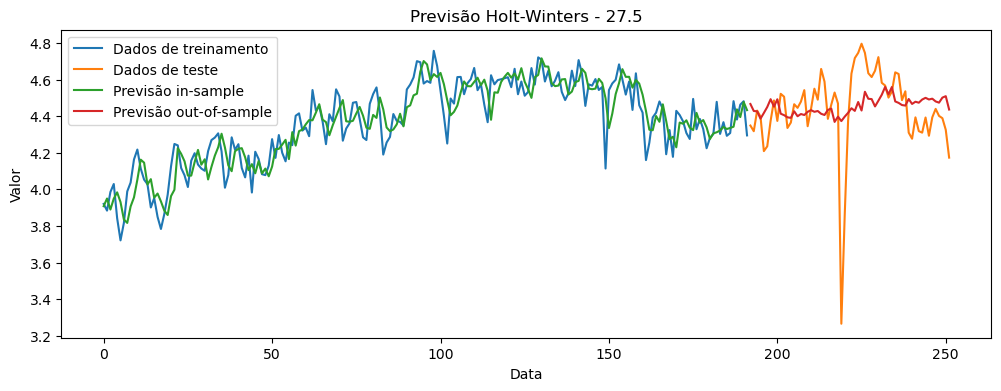

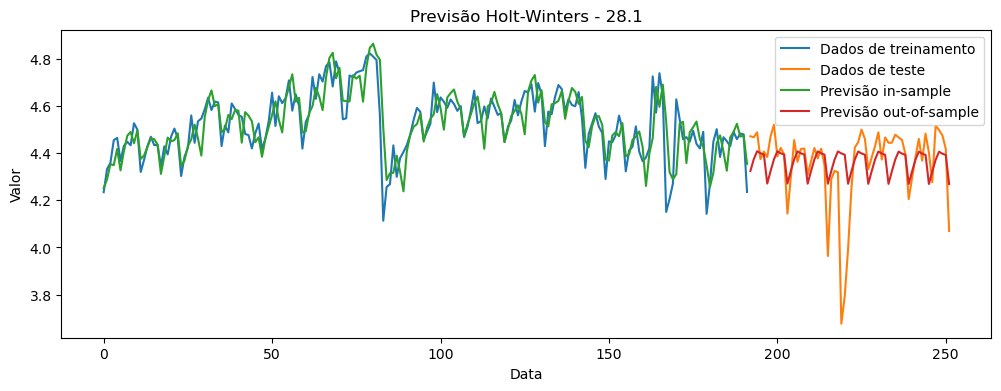

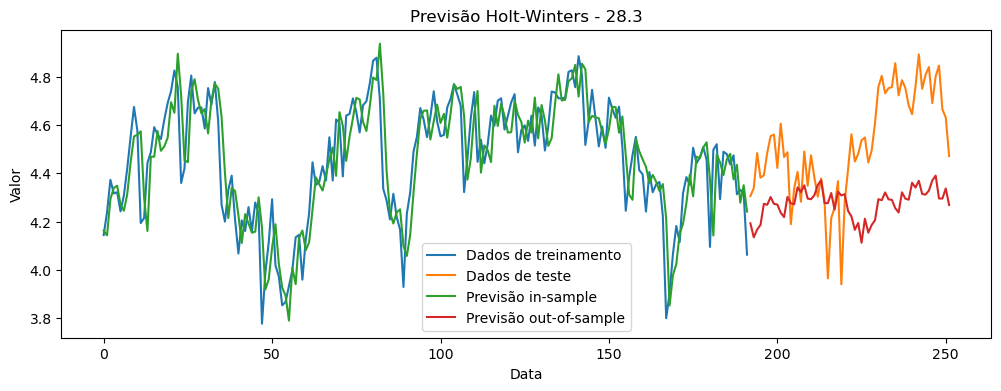

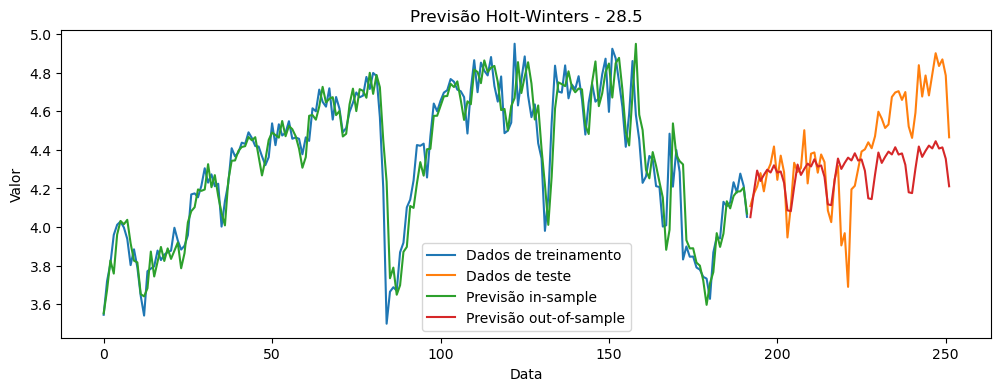

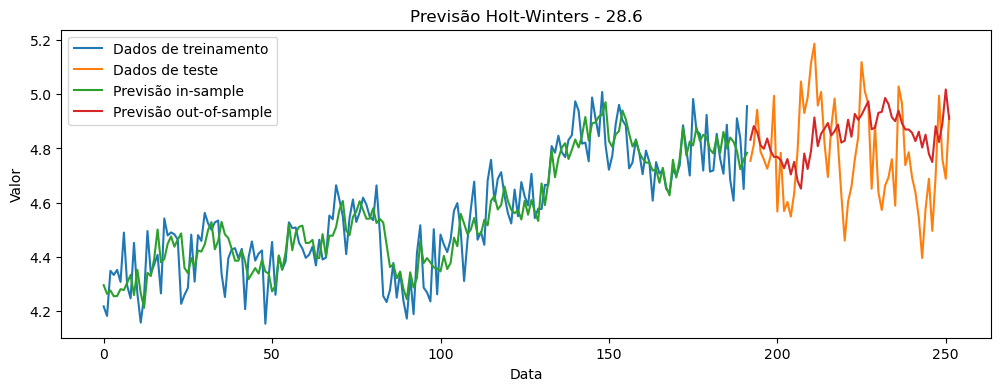

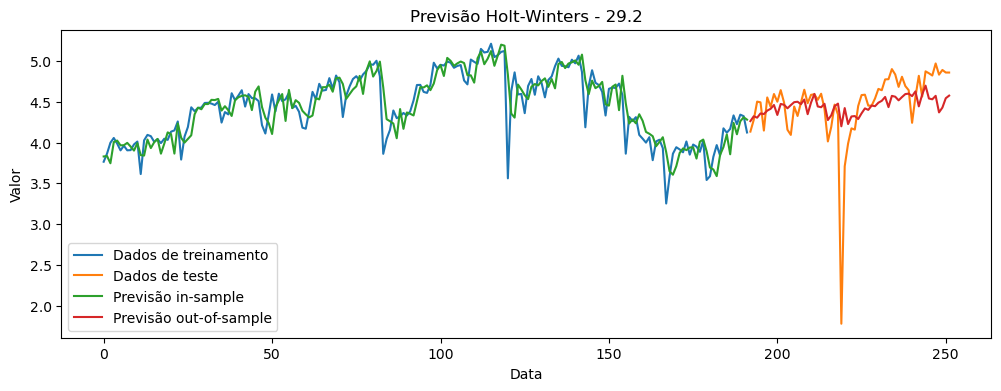

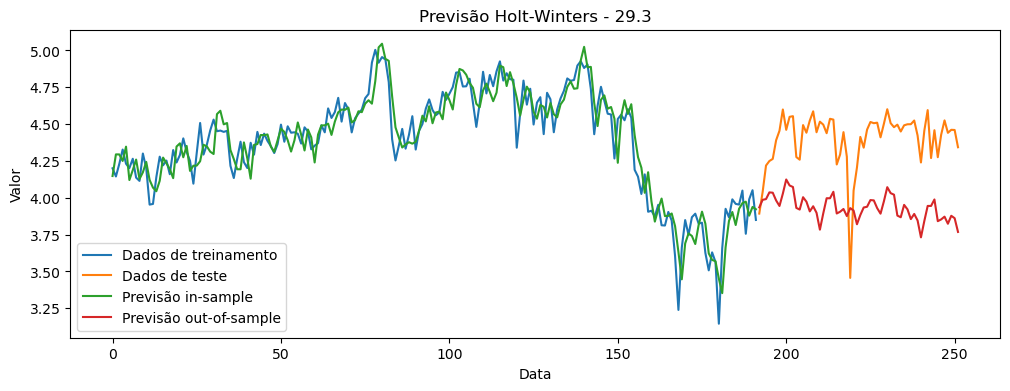

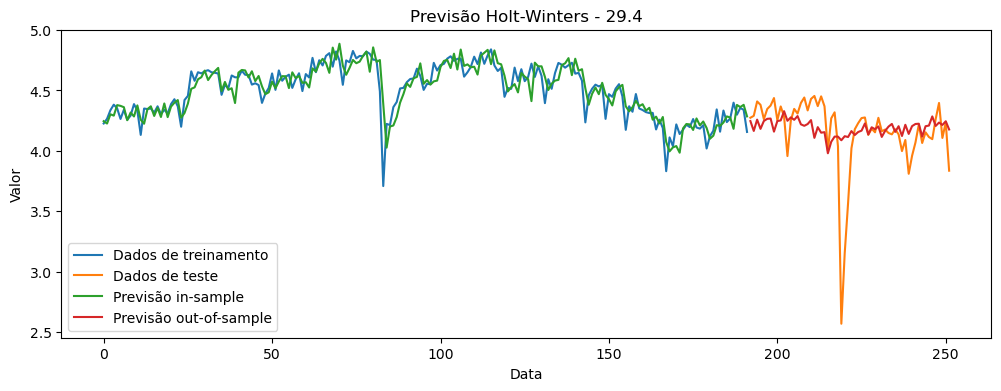

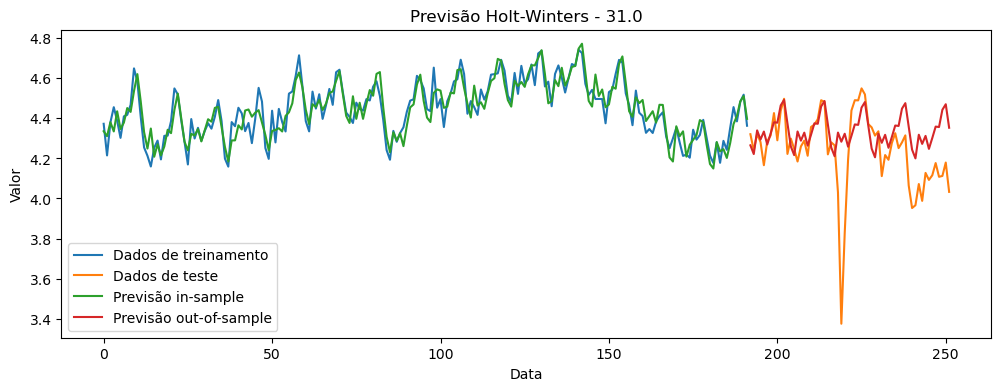

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\alexa\anaconda3\lib\site-packages\sta

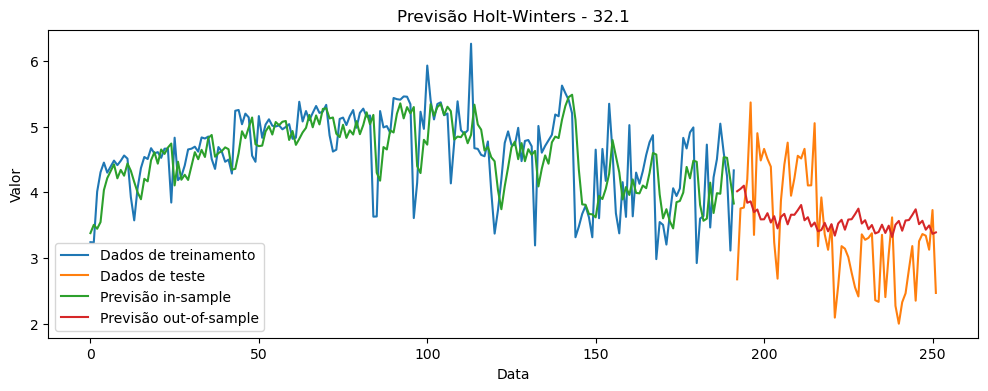

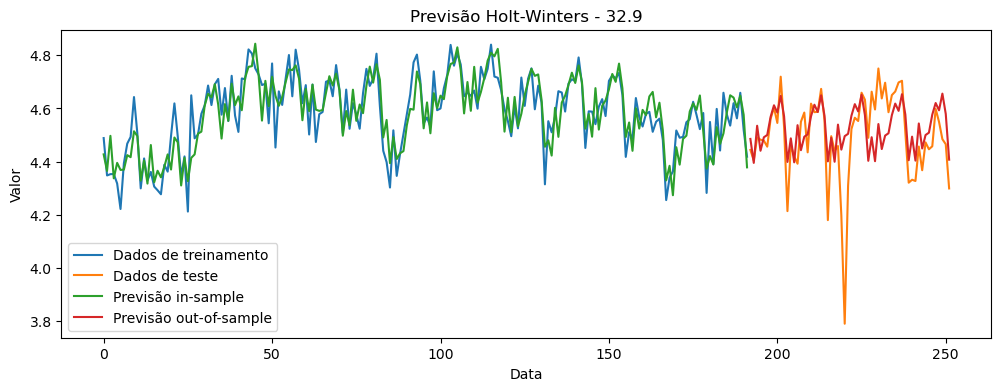

Setor  Best Metric trend Seasonal  Seasonal_Periods  \
0   10.1     0.150628   mul      add                12   
1   10.3     8.014211   mul      add                36   
2   10.4     0.405688   mul      add                36   
3   10.5     1.542068   mul      add                24   
4   10.6     0.173448   add      mul                24   
5   10.7     8.605674   add      add                12   
6   10.8     0.917190   mul      add                 6   
7   11.1     1.055098   add      mul                12   
8   11.2     0.877185   mul      add                24   
9   13.1     1.454741   mul      add                24   
10  13.2     1.774586   mul      mul                12   
11  13.3     3.817530   mul      mul                36   
12  14.1     2.387388   add      mul                12   
13  14.2     6.082824   mul      mul                12   
14  15.1     1.844776   add      mul                32   
15  16.2     0.698323   add      add                33   
16  17.1     0.592184   add      add                37   
17  17.2     0.340964   add      mul                40   
18  17.3     0.172936   mul      mul                12   
19  17.4     0.533409   mul      add                37   
20  19.2     0.546920   add      mul                45   
21  19.3     2.484646   add      mul                12   
22  20.1     0.713073   mul      add                24   
23  20.5     3.779713   add      add                12   
24  20.6     0.848623   add      mul                40   
25  20.7     1.981037   mul      mul                31   
26  22.1     1.073407   mul      add                45   
27  22.2     0.413970   add      add                39   
28  23.1     1.377430   mul      mul                45   
29  23.2     1.381951   add      add                35   
30  23.3     1.240838   add      mul                47   
31  23.4     1.901106   add      mul                40   
32  23.9     0.555011   add      mul                12   
33  24.1     3.080561   mul      add                12   
34  24.2     0.716592   add      add                 6   
35  24.5     5.183406   add      add                12   
36  25.3     1.727648   add      add                12   
37  25.4     0.644983   add      mul                24   
38  26.2     1.705685   add      mul                45   
39  26.4     2.280656   add      add                 6   
40  27.4     1.700319   add      add                37   
41  27.5     2.746513   mul      add                34   
42  28.1     1.420323   mul      add                 6   
43  28.3     6.267219   add      add                34   
44  28.5     3.565077   add      add                12   
45  28.6     2.394659   add      mul                39   
46  29.2     8.957502   add      mul                33   
47  29.3    15.070491   add      add                30   
48  29.4     4.817965   mul      mul                44   
49  31.0     2.327563   mul      add                12   
50  32.1    38.770876   mul      add                17   
51  32.9     1.119092   mul      add                12   

                                               Modelo  MSE_In-Sample  \
0   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.001436   
1   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.025248   
2   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.003052   
3   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.001239   
4   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.000867   
5   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.046606   
6   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.005137   
7   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.002937   
8   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.002563   
9   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.002575   
10  <statsmodels.tsa.holtwinters.results.HoltWinte...       0.002602   
11  <statsmodels.tsa.holtwinters.results.HoltWinte...       0.00

In [6]:
# HW = HoltWinters(tsa.df_macro_sectors.loc[:,['10.1','10.3']])
HW = HoltWinters(tsa.df_macro_sectors)
HW.result_df = HW.select_best_holt_winters_model('eqa', 60) 
HW.result_df

In [7]:
forecast_errors_df = HW.generate_forecast_errors()
forecast_errors_df

forecast_errors_df.to_excel('Forecasting_Holt_winters_eqa_60.xlsx', index=False)
HW.result_df.to_excel('Param_Holt_winters_eqa_60.xlsx', index=False)

In [5]:
HW.result_df


Setor  Best Metric trend Seasonal  Seasonal_Periods  \
0   10.1     0.002510   mul      add                12   
1   10.3     0.133570   mul      add                36   
2   10.4     0.006761   mul      add                36   
3   10.5     0.025701   mul      add                24   
4   10.6     0.002891   add      mul                24   
5   10.7     0.143428   add      add                12   
6   10.8     0.015287   mul      add                 6   
7   11.1     0.017585   add      mul                12   
8   11.2     0.014620   mul      add                24   
9   13.1     0.024246   mul      add                24   
10  13.2     0.029576   mul      mul                12   
11  13.3     0.063625   mul      mul                36   
12  14.1     0.039790   add      mul                12   
13  14.2     0.101380   mul      mul                12   
14  15.1     0.030746   add      mul                32   
15  16.2     0.011639   add      add                33   
16  17.1     0.009870   add      add                37   
17  17.2     0.005683   add      mul                40   
18  17.3     0.002882   mul      mul                12   
19  17.4     0.008890   mul      add                37   
20  19.2     0.009115   add      mul                45   
21  19.3     0.041411   add      mul                12   
22  20.1     0.011885   mul      add                24   
23  20.5     0.062995   add      add                12   
24  20.6     0.014144   add      mul                40   
25  20.7     0.033017   mul      mul                31   
26  22.1     0.017890   mul      add                45   
27  22.2     0.006899   add      add                39   
28  23.1     0.022957   mul      mul                45   
29  23.2     0.023033   add      add                35   
30  23.3     0.020681   add      mul                47   
31  23.4     0.031685   add      mul                40   
32  23.9     0.009250   add      mul                12   
33  24.1     0.051343   mul      add                12   
34  24.2     0.011943   add      add                 6   
35  24.5     0.086390   add      add                12   
36  25.3     0.028794   add      add                12   
37  25.4     0.010750   add      mul                24   
38  26.2     0.028428   add      mul                45   
39  26.4     0.038011   add      add                 6   
40  27.4     0.028339   add      add                37   
41  27.5     0.045775   mul      add                34   
42  28.1     0.023672   mul      add                 6   
43  28.3     0.104454   add      add                34   
44  28.5     0.059418   add      add                12   
45  28.6     0.039911   add      mul                39   
46  29.2     0.149292   add      mul                33   
47  29.3     0.251175   add      add                30   
48  29.4     0.080299   mul      mul                44   
49  31.0     0.038793   mul      add                12   
50  32.1     0.646181   mul      add                17   
51  32.9     0.018652   mul      add                12   

                                               Modelo  MSE_In-Sample  \
0   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.001436   
1   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.025248   
2   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.003052   
3   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.001239   
4   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.000867   
5   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.046606   
6   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.005137   
7   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.002937   
8   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.002563   
9   <statsmodels.tsa.holtwinters.results.HoltWinte...       0.002575   
10  <statsmodels.tsa.holtwinters.results.HoltWinte...       0.002602   
11  <statsmodels.tsa.holtwinters.results.HoltWinte...       0.00